In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [80]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
#case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'
#case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'

#case['name']='OM4p5_CORE2_IAF_gzCOBALT-060822'

#case=ctrl

In [81]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-tun_cy5 gzCOBALT-tun_cy5


In [82]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [83]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5


In [84]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates=['1988-2007','2048-2067']

files=[glob(tmpdir + '/'+ d + '.' + pp_dates[0] + '*.nc') for d in diagTypes]
if not files:
    files=[glob(tmpdir + '/'+ d + '.' + pp_dates[1] + '*.nc') for d in diagTypes]
    
files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.01.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.02.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.03.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.04.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.05.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.06.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.07.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.08.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.09.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-tun_cy5/ocean_cobalt_fdet_100.1988-2007.10.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_

In [85]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
#grid=xr.open_dataset(grid_file)
grid = xr.open_dataset('/work/jyl/tmp/ocean_static.nc')

In [86]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})
ds.depth_levels

<xarray.DataArray 'depth_levels' (z_l: 35)>
array([  5. ,  10. ,  10. ,  15. ,  22.5,  25. ,  25. ,  25. ,  37.5,
        50. ,  50. ,  75. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 175. , 250. , 375. , 500. ,
       500. , 500. , 500. , 500. , 500. , 500. , 500. , 500. ])
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:  Thickness of depth bin
    units:      meters

# Compute bulk diagnostics

In [87]:
intpp=(ds.pp * ds.depth_levels).sum(dim='z_l')
intpp=(intpp * grid.areacello).sum(dim=['yh', 'xh'])
intpp=intpp.groupby('time.month').mean(dim='time').mean(dim='month') * seconds_per_year * carbon_molar_mass
print('net primary production: ' + str(np.format_float_scientific(intpp.values,2)) + ' g C / yr')

net primary production: 4.83e+16 g C / yr


In [88]:
concat_vars = [v for v in ds if 'jprod_ndet' in v]
concat_vars.extend([v for v in ds if 'jaggloss' in v])

totDetProd = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')
totDetProd = (totDetProd * grid.areacello).sum(dim=['xh','yh']).mean(dim='time') * seconds_per_year * cobalt_n_2_c * carbon_molar_mass
print('total detritus production in top 100m: ' + str(np.format_float_scientific(totDetProd.values,2)) + ' g C / yr')

total detritus production in top 100m: 7.9e+15 g C / yr


In [89]:
concat_vars = [v for v in ds if 'fndet' in v]
export100 = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')
export100 = (export100 * grid.areacello).sum(dim=['yh', 'xh'])
export100 = export100.groupby('time.month').mean(dim='time').mean(dim='month') * seconds_per_year * cobalt_n_2_c * carbon_molar_mass
print('carbon export at 100 m: ' + str(np.format_float_scientific(export100.values,2)) + ' g C / yr')

carbon export at 100 m: 5.82e+15 g C / yr


In [90]:
totgraz=ds.graz * grid.areacello * ds.depth_levels
totgraz=totgraz.sum(dim=['yh','xh','z_l'])
totgraz=totgraz.groupby('time.month').mean(dim='time').mean(dim='month') * seconds_per_year * carbon_molar_mass
print('total grazing: ' + str(np.format_float_scientific(totgraz.values,2)) + ' g C / yr')

total grazing: 3.47e+16 g C / yr


In [91]:
#totZingest = (ds.jingest_n_nsmz_100 + ds.jingest_n_nmdz_100 + ds.jingest_n_nlgz_100 + ds.jingest_n_nsmt_100 + ds.jingest_n_nlgt_100) 
#concat_vars=[v for v in ds if 'jingest_n_n' in v]
concat_vars=['jingest_n_n' + v + '_100' for v in zoo_varlist]
totZingest = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')

totZingest = (totZingest * grid.areacello).sum(dim=['yh','xh'])
totZingest = totZingest.groupby('time.month').mean(dim='time').mean(dim='month') * seconds_per_year * cobalt_n_2_c * carbon_molar_mass
print('total zooplankton ingestion (top 100 m): ' + str(np.format_float_scientific(totZingest.values,2)) + ' g C / yr')

total zooplankton ingestion (top 100 m): 4.5e+16 g C / yr


In [92]:
#hploss = (ds.jhploss_nmdz_100 + ds.jhploss_nlgz_100 + ds.jhploss_nsmt_100 + ds.jhploss_nlgt_100) 
concat_vars=[v for v in ds if 'jhploss' in v]
hploss = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')
hploss = (hploss * grid.areacello).sum(dim=['yh','xh'])
hploss = hploss.groupby('time.month').mean(dim='time').mean(dim='month') * seconds_per_year * cobalt_n_2_c * carbon_molar_mass
print('total loss to HP (top 100 m): ' + str(np.format_float_scientific(hploss.values,2)) + ' g C / yr')

total loss to HP (top 100 m): 1.83e+15 g C / yr


In [93]:
#frac_smz_ingest = ds.jingest_n_nsmz_100 / (ds.jingest_n_nsmz_100 + ds.jingest_n_nmdz_100 + ds.jingest_n_nlgz_100 + ds.jingest_n_nsmt_100 + ds.jingest_n_nlgt_100) 
concat_vars=['jingest_n_n' + v + '_100' for v in zoo_varlist]
frac_smz_ingest = ds.jingest_n_nsmz_100 / (xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var'))
frac_smz_ingest = frac_smz_ingest.mean()
print('fraction of small zooplankton ingestion: ' + str(np.round(frac_smz_ingest.values * 100)) + '%')

fraction of small zooplankton ingestion: 67.0%


In [94]:
phyc_zint = (ds.phyc.mean(dim='time') * ds.depth_levels).sum(dim='z_l') * carbon_molar_mass #g C m-2
phyc_zint = phyc_zint.rename('phyc_zint')
val = (phyc_zint * grid.areacello).sum(dim=['yh', 'xh']).values
print('phytoplankton biomass (depth integrated): ' + str(np.format_float_scientific(val,2)) + ' g C')

phytoplankton biomass (depth integrated): 4.6e+14 g C


In [95]:
zooc_zint = (ds.zooc.mean(dim='time') * ds.depth_levels).sum(dim='z_l') * carbon_molar_mass #g C m-2
val = (zooc_zint * grid.areacello).sum(dim=['yh','xh']).values
print('zooplankton biomass (depth integrated): ' + str(np.format_float_scientific(val,2)) + ' g C')

zooplankton biomass (depth integrated): 6.74e+14 g C


# Compute tunicate and mesozooplankton properties

In [96]:
tunmass_zint = (ds.ztunicate * ds.depth_levels).sum(dim='z_l') * carbon_molar_mass # g C m-2
tunmass_zint = tunmass_zint.rename('tunmass_zint')

val = (tunmass_zint * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values
print('Total Tunicate Biomass (depth integrated): ' + str(np.round(val/1e12,1)) + ' Tg C')

Total Tunicate Biomass (depth integrated): 89.0 Tg C


In [97]:
val1 =(ds.nsmt_100.mean(dim='time') * grid.areacello).sum(dim=['yh', 'xh']).values * cobalt_n_2_c * carbon_molar_mass
print('Small Tunicate total biomass (top 100m): ' + str(np.round(val1/1e12,2)) + ' Tg C')

val2 =(ds.nlgt_100.mean(dim='time') * grid.areacello).sum(dim=['yh', 'xh']).values * cobalt_n_2_c * carbon_molar_mass
print('Large Tunicate total biomass (top 100m): ' + str(np.round(val2/1e12,1)) + ' Tg C')

print('Total Tunicate biomass (top 100m): ' + str(np.round((val1+val2)/1e12,1)) + ' Tg C')

Small Tunicate total biomass (top 100m): 5.42 Tg C
Large Tunicate total biomass (top 100m): 69.1 Tg C
Total Tunicate biomass (top 100m): 74.5 Tg C


In [98]:
mesomass_zint = (ds.zmeso * ds.depth_levels).sum(dim='z_l') * carbon_molar_mass # g C m-2
mesomass_zint = mesomass_zint.rename('tunmass_zint')

val=(mesomass_zint * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values
print('Crustacean mesozooplankton biomass (depth integrated): ' + str(np.format_float_scientific(val,2)) + ' g C')

Crustacean mesozooplankton biomass (depth integrated): 3.26e+14 g C


In [99]:
val=((((ds.nlgz_100 + 0.5*ds.nmdz_100).mean(dim='time')*grid.areacello).sum()) * cobalt_n_2_c * carbon_molar_mass).values
print('Med/large mesozooplankton biomass (to compare against COPEPOD) (top 100 m): ' + str(np.round(val/1e12,2)) + ' Tg C')

Med/large mesozooplankton biomass (to compare against COPEPOD) (top 100 m): 181.75 Tg C


In [100]:
tunprod100 = (ds.jprod_nsmt_100 + ds.jprod_nlgt_100) * seconds_per_day * cobalt_n_2_c # mol m-2 d-1
tunprod100 = tunprod100.rename('tunprod100')
#tunprod100.compute()

In [101]:
mzprod100 = (ds.jprod_nmdz_100 + ds.jprod_nlgz_100) * seconds_per_day * cobalt_n_2_c # mol m-2 d-1
mzprod100 = mzprod100.rename('mzprod100')

chl100 = (ds.chl * ds.depth_levels).isel(z_l=slice(None,10)).sum(dim='z_l') * 1e3 # g m-2
chl100 = chl100.rename('chl100')

In [102]:
val=(tunprod100 * carbon_molar_mass * 365. * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
print('Tunicate production, upper 100 m (depth integrated): ' + str(np.format_float_scientific(val,2)) + ' g C y-1')

Tunicate production, upper 100 m (depth integrated): 3.97e+14 g C y-1


In [103]:
val=(mzprod100 * carbon_molar_mass * 365. * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
print('Mesozooplankton production, upper 100 m (depth integrated): ' + str(np.format_float_scientific(val,2)) + ' g C y-1')

zratio=val/intpp.values
print('Z-ratio (mesozooplankton production/NPP), mean: ' + str(np.round(zratio, 3)))

Mesozooplankton production, upper 100 m (depth integrated): 3.26e+15 g C y-1
Z-ratio (mesozooplankton production/NPP), mean: 0.068


In [104]:
smtdetprod100 = (ds.jprod_ndet_nsmt_100.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) * seconds_per_year * cobalt_n_2_c * carbon_molar_mass

concat_vars = [v for v in ds if 'jprod_ndet_nlgt' in v]
lgtdetprod100 = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')
lgtdetprod100 = (lgtdetprod100.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) * seconds_per_year * cobalt_n_2_c * carbon_molar_mass

print('small tunicates detritus production: ' + str(np.round(smtdetprod100.values/1e15,2)) + ' Pg C y-1')
print('large tunicates detritus production: ' + str(np.round(lgtdetprod100.values/1e15,2)) + ' Pg C y-1')

small tunicates detritus production: 0.17 Pg C y-1
large tunicates detritus production: 0.63 Pg C y-1


In [105]:
fishdetprod100 = (ds.jprod_ndet_hp_100.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) * seconds_per_year * cobalt_n_2_c * carbon_molar_mass

print('fish detritus production: ' + str(np.round(fishdetprod100.values/1e15,2)) + ' Pg C y-1')

fish detritus production: 0.64 Pg C y-1


Production / Biomass
--

In [27]:
#tunicate P/B
P=(tunprod100 * carbon_molar_mass * 365. * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=((ds.nsmt_100 + ds.nlgt_100) * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Tunicate P/B: ' + str(np.round(P/B,2)) + ' y-1')

#Appendicularian P/B
P=(ds.jprod_nsmt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=((ds.nsmt_100) * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Small Tunicate P/B: ' + str(np.round(P/B,2)) + ' y-1')

#Salps P/B
P=(ds.jprod_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=((ds.nlgt_100) * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Large Tunicate P/B: ' + str(np.round(P/B,2)) + ' y-1')

Tunicate P/B: 5.28 y-1
Small Tunicate P/B: 5.35 y-1
Large Tunicate P/B: 5.27 y-1


In [28]:
#mesozooplankton P/B
P=(mzprod100 * carbon_molar_mass * 365. * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=((ds.nmdz_100 + ds.nlgz_100) * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Mesozooplankton P/B: ' + str(np.round(P/B,2)) + ' y-1')

#Medium Zooplankton P/B
P=(ds.jprod_nmdz_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=(ds.nmdz_100 * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Medium Zooplankton P/B: ' + str(np.round(P/B,2)) + ' y-1')

#Large Zooplankton P/B
P=(ds.jprod_nlgz_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
B=(ds.nlgz_100 * grid.areacello).sum(dim=['yh', 'xh']).mean(dim='time').values * cobalt_n_2_c * carbon_molar_mass
print('Large Zooplankton P/B: ' + str(np.round(P/B,2)) + ' y-1')

Mesozooplankton P/B: 12.45 y-1
Medium Zooplankton P/B: 16.56 y-1
Large Zooplankton P/B: 6.22 y-1


## Fraction of mortality to consumption vs jelly-falls
#### Luo et al. 2020 model suggests jelly-falls should represent ~22% of production, and ~35% of total mortality. (therefore, predation would be 65% of total mortality)

In [29]:
tun_mort_pred_tot = ((ds.jzloss_nlgt_100 + ds.jhploss_nlgt_100) * cobalt_n_2_c * carbon_molar_mass * 
                     seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
tun_mort_pred_zoo = (ds.jzloss_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
tun_mort_pred_hp = (ds.jhploss_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
salpProd=(ds.jprod_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values

print('Salp prod to predators: ' + str(np.round(tun_mort_pred_tot/salpProd,3)) + ' y-1')
print('Salp mortality to predation: ' + str(np.format_float_scientific(tun_mort_pred_tot,2)) + ' y-1')
print('Salp mortality to zooplankton predation: ' + str(np.format_float_scientific(tun_mort_pred_zoo,2)) + ' y-1')
print('Salp mortality to HP predation: ' + str(np.format_float_scientific(tun_mort_pred_hp,2)) + ' y-1')


Salp prod to predators: 0.542 y-1
Salp mortality to predation: 1.92e+14 y-1
Salp mortality to zooplankton predation: 1.19e+14 y-1
Salp mortality to HP predation: 7.35e+13 y-1


In [30]:
if 'jaggloss_nlgt_100' in ds:
    tun_jellyfalls = (ds.jaggloss_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
    salpProd=(ds.jprod_nlgt_100 * cobalt_n_2_c * carbon_molar_mass * seconds_per_year * grid.areacello).sum(dim=['xh','yh']).mean(dim='time').values
    print('Salp mortality via jellyfalls: ' + str(np.format_float_scientific(tun_jellyfalls ,2)) + ' y-1')
    print('Fraction of total salp mortality to jellyfalls: ' + str(np.round(tun_jellyfalls/(tun_mort_pred_tot+tun_jellyfalls),2)) + ' y-1')
    print('Fraction of Salp production lost to jellyfalls: ' + str(np.round(tun_jellyfalls/salpProd,2)) + ' y-1')


Salp mortality via jellyfalls: 1.27e+14 y-1
Fraction of total salp mortality to jellyfalls: 0.4 y-1
Fraction of Salp production lost to jellyfalls: 0.36 y-1


Eval Chlorophyll-Biomass slope
-------------

In [31]:
def abline(slope, intercept, **kwargs):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', **kwargs)

In [32]:
import pandas as pd
dt2=pd.read_csv('/work/jyl/proj/gz_COBALT/dt2cast_ZerosAsMinValue.csv')

In [33]:
from scipy import stats
y=np.log10(dt2.Appendicularians)
x=np.log10(dt2.chl_gs_mean)
mask = np.isfinite(x) & np.isfinite(y)
app_lm=stats.linregress(x[mask],y[mask])
print(app_lm)

y=np.log10(dt2.Thaliaceans)
x=np.log10(dt2.chl_gs_mean)
mask = np.isfinite(x) & np.isfinite(y)
thal_lm=stats.linregress(x[mask],y[mask])
print(thal_lm)

y=np.log10(dt2.Copepods)
x=np.log10(dt2.chl_gs_mean)
mask = np.isfinite(x) & np.isfinite(y)
cope_lm=stats.linregress(x[mask],y[mask])
print(cope_lm)

y=np.log10(dt2.Tunicates)
x=np.log10(dt2.chl_gs_mean)
mask = np.isfinite(x) & np.isfinite(y)
tun_lm=stats.linregress(x[mask],y[mask])
print(tun_lm)

LinregressResult(slope=0.6266152195178636, intercept=-1.6974030918795975, rvalue=0.2275251570694458, pvalue=3.926243999688113e-43, stderr=0.044903204415309816, intercept_stderr=0.03473414656800233)
LinregressResult(slope=0.2163563551114854, intercept=-0.5858929175810268, rvalue=0.09236711982299184, pvalue=1.9822115388836256e-09, stderr=0.0359844885002872, intercept_stderr=0.027356390232681722)
LinregressResult(slope=0.5724557321918835, intercept=0.7227737636958664, rvalue=0.529537078908582, pvalue=0.0, stderr=0.009448498247281967, intercept_stderr=0.007055783640586123)
LinregressResult(slope=0.23480086380935075, intercept=-0.6467442815327124, rvalue=0.09902521955910874, pvalue=4.723001462614828e-12, stderr=0.033876488400441045, intercept_stderr=0.025169102310368573)


In [34]:
APP_CORR = 10 # REMSEN ET AL. 2004 (tables 4-5) suggest it should range from 5-15x for tunicates
ya=np.log10(dt2.Appendicularians * APP_CORR)
xa=np.log10(dt2.chl_gs_mean)
maska = np.isfinite(xa) & np.isfinite(ya)
app_lm_corr=stats.linregress(xa[maska],ya[maska])

THAL_CORR = 10 # REMSEN ET AL. 2004 (tables 4-5) suggest it should range from 5-15x for tunicates
yt=np.log10(dt2.Thaliaceans * THAL_CORR)
xt=np.log10(dt2.chl_gs_mean)
maskt = np.isfinite(xt) & np.isfinite(yt)
thal_lm_corr=stats.linregress(xt[maskt],yt[maskt])
thal_lm_corr

#LOWER BOUND
APP_CORR_LOW = 5
ya=np.log10(dt2.Appendicularians * APP_CORR_LOW)
mask = np.isfinite(xa) & np.isfinite(ya)
app_lm_corrlow=stats.linregress(xa[maska],ya[maska])
APP_CORR_HIGH = 15
ya=np.log10(dt2.Appendicularians * APP_CORR_HIGH)
mask = np.isfinite(xa) & np.isfinite(ya)
app_lm_corrhigh=stats.linregress(xa[maska],ya[maska])

THAL_CORR_LOW = 5
yt=np.log10(dt2.Thaliaceans * THAL_CORR_LOW)
maskt = np.isfinite(xt) & np.isfinite(yt)
thal_lm_corrlow=stats.linregress(xt[maskt],yt[maskt])
THAL_CORR_HIGH = 15
yt=np.log10(dt2.Thaliaceans * THAL_CORR_HIGH)
maskt = np.isfinite(xt) & np.isfinite(yt)
thal_lm_corrhigh=stats.linregress(xt[maskt],yt[maskt])

## Regrid onto observational points

In [35]:
var_keep = ['nsmt_100', 'nlgt_100', 'nmdz_100', 'nlgz_100', 'chl', 'xh', 'yh']
do = ds.drop([v for v in ds.variables if v not in var_keep])
do = do.where(do.z_l == 0, drop=True)
do = do.squeeze(drop=True)
do = do.rename({'xh': 'lon', 'yh': 'lat', 'chl':'surf_chl'})

In [36]:
for var in ['surf_chl','nsmt_100','nlgt_100','nmdz_100','nlgz_100']:
    SH_subset = do[var].where(do.lat < 0,drop=True).values
    SH_subset = np.roll(SH_subset, shift=6, axis=0)
    full_field = do[var].values
    full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset
    
    # keep only growing season
    winter = full_field[[0,1,11],:,:]
    spring = full_field[[2,3,4],:,:]
    summer = full_field[[5,6,7],:,:]
    fall = full_field[[8,9,10],:,:]

    
    # southern hemisphere high latitudes
    winter[:,0:np.size(do.lat[do.lat < -60]),:] = np.nan
    #spring[:,0:np.size(do.lat[do.lat < -60]),:] = np.nan
    fall[:,0:np.size(do.lat[do.lat < -60]),:] = np.nan

    # southern hemisphere mid latitudes
    winter[:,np.size(do.lat[do.lat < -60]):np.size(do.lat[do.lat < -30]),:] = np.nan
    fall[:,np.size(do.lat[do.lat < -60]):np.size(do.lat[do.lat < -30]),:] = np.nan
    
    # northern hemisphere high latitudes
    winter[:,np.size(do.lat[do.lat < 60]):,:] = np.nan
    #spring[:,np.size(do.lat[do.lat < 60]):,:] = np.nan
    fall[:,np.size(do.lat[do.lat < 60]):,:] = np.nan

    # northern hemisphere mid latitudes
    winter[:,np.size(do.lat[do.lat < 30]):np.size(do.lat[do.lat < 60]),:] = np.nan
    fall[:,np.size(do.lat[do.lat < 30]):np.size(do.lat[do.lat < 60]),:] = np.nan    
    
    full_field[[0,1,11],:,:] = winter
    full_field[[2,3,4],:,:] = spring
    full_field[[5,6,7],:,:] = summer
    full_field[[8,9,10],:,:] = fall

    
    svar = var + '_gs'
    do[svar] = xr.DataArray(full_field, dims=do[var].dims, coords=do[var].coords)


In [37]:
apps=dt2[['lon','lat','chl_gs_mean','Appendicularians']].dropna()
thals=dt2[['lon','lat','chl_gs_mean','Thaliaceans']].dropna()

In [38]:
apps_locs=xr.Dataset()
apps_locs['lon']=xr.DataArray(data=apps.lon.values, dims=('location'))
apps_locs['lat']=xr.DataArray(data=apps.lat.values, dims=('location'))

thals_locs=xr.Dataset()
thals_locs['lon']=xr.DataArray(data=thals.lon.values, dims=('location'))
thals_locs['lat']=xr.DataArray(data=thals.lat.values, dims=('location'))

In [39]:
import xesmf as xe

regridder_apps = xe.Regridder(do, apps_locs, 'bilinear', locstream_out=True, reuse_weights=True)
regridder_thals = xe.Regridder(do, thals_locs, 'bilinear', locstream_out=True, reuse_weights=True)

Reuse existing file: bilinear_576x720_1x3569.nc
Reuse existing file: bilinear_576x720_1x4203.nc


In [40]:
ds_apps_rg = regridder_apps(do)
ds_thals_rg = regridder_thals(do)

using dimensions ('lat', 'lon') from data variable surf_chl as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable surf_chl as the horizontal dimensions for this dataset.


In [41]:
y=np.log10(ds_apps_rg.nsmt_100_gs.mean(dim='time') * carbon_molar_mass * cobalt_n_2_c * 1e3 / 100) # mg C m-3
x=np.log10(ds_apps_rg.surf_chl_gs.mean(dim='time') * 1e6) # mg m-3
mask = np.isfinite(x) & np.isfinite(y)
model_app_lm=stats.linregress(x[mask],y[mask])
print(model_app_lm)

y=np.log10(ds_thals_rg.nlgt_100_gs.mean(dim='time') * carbon_molar_mass * cobalt_n_2_c * 1e3 / 100) # mg C m-2
x=np.log10(ds_thals_rg.surf_chl_gs.mean(dim='time') * 1e6) # mg m-3
mask = np.isfinite(x) & np.isfinite(y)
model_thal_lm=stats.linregress(x[mask],y[mask])
print(model_thal_lm)

LinregressResult(slope=0.8248730799792705, intercept=-0.32343259431039795, rvalue=0.9114760933142745, pvalue=0.0, stderr=0.006358228960232877, intercept_stderr=0.005513913585957093)
LinregressResult(slope=0.572693381003156, intercept=0.5963069255801169, rvalue=0.7206542817776767, pvalue=0.0, stderr=0.00861176438746981, intercept_stderr=0.007243658662293837)


In [42]:
# Crustacean Mesozooplankton

In [43]:
copes=dt2[['lon','lat','chl_gs_mean','Copepods']].dropna()
cope_locs=xr.Dataset()
cope_locs['lon']=xr.DataArray(data=copes.lon.values, dims=('location'))
cope_locs['lat']=xr.DataArray(data=copes.lat.values, dims=('location'))

regridder_cope = xe.Regridder(do, cope_locs, 'bilinear', locstream_out=True, reuse_weights=True)
ds_cope_rg = regridder_cope(do)

Reuse existing file: bilinear_576x720_1x9422.nc
using dimensions ('lat', 'lon') from data variable surf_chl as the horizontal dimensions for this dataset.


In [44]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Line2D([0], [0], marker='o', color='C0', markerfacecolor='C0', markersize=4, ls='None'),
                Line2D([0], [0], marker='o', color='k', markerfacecolor='k', markersize=4, ls='None'),
               (Patch(facecolor='#dddddd', edgecolor='grey'), Line2D([0], [0], color='#666666', lw=2, ls='--')),
                Line2D([0], [0], color='k', lw=2, ls='--')]
custom_lines2 = [Line2D([0], [0], marker='o', color='C0', markerfacecolor='C0', markersize=4, ls='None'),
                Line2D([0], [0], marker='o', color='k', markerfacecolor='k', markersize=4, ls='None'),
                Line2D([0], [0], color='#666666', lw=2, ls='--'),
                Line2D([0], [0], color='k', lw=2, ls='--')]
custom_labels=['Adj. Obs. Points','Model Points','Adj. Obs. Trend','Model Trend']

In [45]:
labels=['a','b','c']
if '_b' in case:
    labels=['d','e','f']
if '_c' in case:
    labels=['g','h','i']
if '_d' in case:
    labels=['j','k','l']
if '_e' in case:
    labels=['m','n','o']
print(labels)

['a', 'b', 'c']


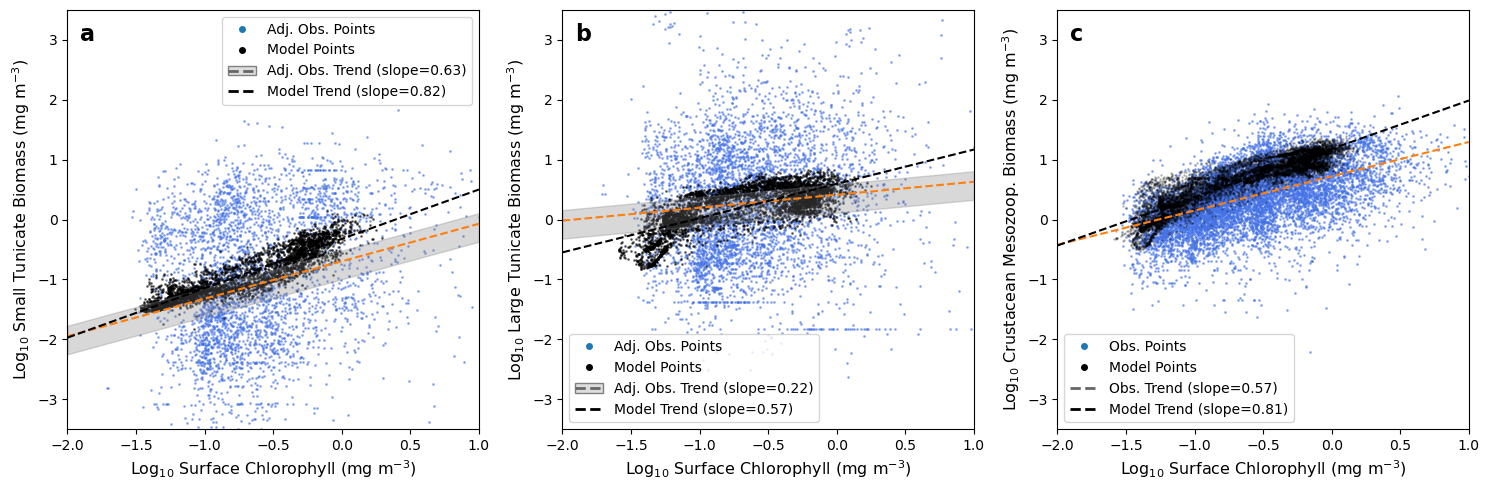

In [46]:
fig=plt.figure(figsize=(15,5))
gs=gridspec.GridSpec(1,3)

fig.add_subplot(gs[0,0])
plt.ylim(-3.5,3.5)
plt.xlim(-2,1)
y=ds_apps_rg.nsmt_100_gs.mean(dim='time') * carbon_molar_mass * cobalt_n_2_c * 1e3 / 100 # mg C m-3
x=ds_apps_rg.surf_chl_gs.mean(dim='time') * 1e6 # mg m-3
yd=dt2.Appendicularians
xd=dt2.chl_gs_mean
plt.scatter(x=np.log10(xd),y=np.log10(yd*APP_CORR), alpha=0.5,s=1, c='#4573e6')
plt.scatter(x=np.log10(x),y=np.log10(y), alpha=0.5,s=1, c='black')

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
plt.fill_between(x_vals, app_lm_corrlow.intercept + app_lm_corrlow.slope * x_vals, 
                 app_lm_corrhigh.intercept + app_lm_corrhigh.slope * x_vals,
                 alpha=0.30, color='grey', interpolate=True)
abline(slope=app_lm_corr.slope, intercept=app_lm_corr.intercept, c='C1')
abline(slope=model_app_lm.slope, intercept=model_app_lm.intercept, c='black')
plt.gca().text(0.03, 0.97, labels[0], transform=plt.gca().transAxes, fontsize=16, fontweight='bold', va='top')

plt.legend(custom_lines, ['Adj. Obs. Points','Model Points',
                          'Adj. Obs. Trend (slope='+str(np.round(app_lm_corr.slope,2))+')',
                          'Model Trend (slope='+str(np.round(model_app_lm.slope,2))+')'])
plt.xlabel('Log$_{10}$ Surface Chlorophyll (mg m$^{-3}$)', fontsize=11.5)
plt.ylabel('Log$_{10}$ Small Tunicate Biomass (mg m$^{-3}$)', fontsize=11.5)


fig.add_subplot(gs[0,1])
plt.ylim(-3.5,3.5)
plt.xlim(-2,1)
y=ds_thals_rg.nlgt_100_gs.mean(dim='time') * carbon_molar_mass * cobalt_n_2_c * 1e3 / 100 # mg C m-2
x=ds_thals_rg.surf_chl_gs.mean(dim='time') * 1e6 # mg m-3
yd=dt2.Thaliaceans
xd=dt2.chl_gs_mean
plt.scatter(x=np.log10(xd),y=np.log10(yd*THAL_CORR), alpha=0.5,s=1, c='#4573e6')
plt.scatter(x=np.log10(x),y=np.log10(y), alpha=0.5,s=1, c='black')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
plt.fill_between(x_vals, thal_lm_corrlow.intercept + thal_lm_corrlow.slope * x_vals, 
                thal_lm_corrhigh.intercept + thal_lm_corrhigh.slope * x_vals,
                alpha=0.30, color='grey', interpolate=True)
abline(slope=thal_lm_corr.slope, intercept=thal_lm_corr.intercept,c='C1')
abline(slope=model_thal_lm.slope, intercept=model_thal_lm.intercept,c='black')
plt.gca().text(0.03, 0.97, labels[1], transform=plt.gca().transAxes, fontsize=16, fontweight='bold', va='top')

plt.legend(custom_lines, ['Adj. Obs. Points','Model Points',
                          'Adj. Obs. Trend (slope='+str(np.round(thal_lm_corr.slope,2))+')',
                          'Model Trend (slope='+str(np.round(model_thal_lm.slope,2))+')'])
plt.xlabel('Log$_{10}$ Surface Chlorophyll (mg m$^{-3}$)', fontsize=11.5)
plt.ylabel('Log$_{10}$ Large Tunicate Biomass (mg m$^{-3}$)', fontsize=11.5)

fig.add_subplot(gs[0,2])
plt.ylim(-3.5,3.5)
plt.xlim(-2,1)
yd=np.log10(dt2.Copepods)
xd=np.log10(dt2.chl_gs_mean)
maskd = np.isfinite(xd) & np.isfinite(yd)
obs_cope_lm=stats.linregress(xd[maskd],yd[maskd])
plt.scatter(x=xd,y=yd, alpha=0.5,s=1, c='#4573e6')

y=np.log10((ds_cope_rg.nlgz_100_gs + 0.5*ds_cope_rg.nmdz_100_gs).mean(dim='time') * carbon_molar_mass * cobalt_n_2_c * 1e3 / 100)
x=np.log10(ds_cope_rg.surf_chl_gs.mean(dim='time') * 1e6)
mask = np.isfinite(x) & np.isfinite(y)
model_cope_lm=stats.linregress(x[mask],y[mask])
plt.scatter(x=x,y=y, alpha=0.2,s=0.8, c='black')

abline(slope=obs_cope_lm.slope, intercept=obs_cope_lm.intercept, c='C1')
abline(slope=model_cope_lm.slope, intercept=model_cope_lm.intercept, c='black')
plt.gca().text(0.03, 0.97, labels[2], transform=plt.gca().transAxes, fontsize=16, fontweight='bold', va='top')
plt.xlabel('Log$_{10}$ Surface Chlorophyll (mg m$^{-3}$)', fontsize=11.5)
plt.ylabel('Log$_{10}$ Crustacean Mesozoop. Biomass (mg m$^{-3}$)', fontsize=11.5)

plt.legend(custom_lines2, ['Obs. Points','Model Points',
                          'Obs. Trend (slope='+str(np.round(obs_cope_lm.slope,2))+')',
                          'Model Trend (slope='+str(np.round(model_cope_lm.slope,2))+')'])


plt.tight_layout()

plt.savefig('plots/'+fig_casename+'_'+pp_dates[0]+'_Biomass-Chl_Relationship.png', dpi=300, bbox_inches='tight')